# Background

This notebook proposes a method for analysing text data to detect both topic and sentiment, with the potential application of being used to identify misuse of payment text fields for harassment or abuse.</br>

# Data

The dataset used for this example consists of ~3 million human-generated comments, tweets and texts, classified as "toxic" or "not toxic". Datasets of this kind are often used for online content moderation models, but without a publicly available dataset for payment text fields, this was considered the most practically relevant substitute as 1) it contains examples of "toxic" language / sentiment (inc. harassment, insults, threats) which we want to detect, and 2) contains informal / colloquial language of the kind that might be used in a payment text field by individuals (as opposed to e.g. a business-generated payment text field). 
</br></br>
Full documentation of this dataset can be found here: https://huggingface.co/datasets/FredZhang7/toxi-text-3M

# Method

The proposed method involves using both topic analysis and sentiment analysis in conjunction.</br></br>
**Sentiment analysis** can be performed first on the dataset in order to classify whether a text snippet is toxic or not. Current state of the art models such as BERT (and variations such as RoBERTa) make use of contextual word embeddings such that even if the text does not contain key trigger words (as may be contained in a term list / lexicon), the sentiment of the text (such as anger) can be extracted from the full context.</br></br>
**Topic analysis** is used to detect key themes and topics in a text snippet. Some payment text fields may use neutral language, that would not be detected as negative by a sentiment analysis model. In this case, using topic analysis may provide extra insight into the nature of the payment text. This could also be used to detect communication that is criminal but not specifically abusive.</br></br>
These two methods can be combined to create a more well-rounded insight into the intent behind a payment text field, capturing both the topic and the overall sentiment. In addition, further analysis could be done to investigate any potential correlation or predictive relationship between the sentiment / "toxicity" of a payment field, and its topic. 

# Code

The below example outlines the process of performing a topic analysis on text fields, using the dataset introduced above. `BERTopic` is used as it is considered to be one of the state-of-the-art models for topic analysis, amongst others such as LDA and GPT. A full analysis would involve comparing the performance of each of these models, however only the BERTopic implementation is shown here.</br></br>
Topic analysis using BERTopic consists of the following steps:
1. Creating the embeddings
2. Reducing the dimensionality of the embeddings (the embeddings can be huge, which can also make it difficult to visualise clusters in subsequent steps)
3. Create clusters of text snippets that are detected to have similar topics
4. For each cluster, extract the key topics

# Setup

In [228]:
import os, sys
import pandas as pd

from datasets import load_dataset, load_dataset_builder
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

from umap import UMAP
from hdbscan import HDBSCAN

# Load dataset

In [11]:
dataset = load_dataset("FredZhang7/toxi-text-3M")
dataset

Found cached dataset csv (/Users/kzhou/.cache/huggingface/datasets/FredZhang7___csv/FredZhang7--toxi-text-3M-8d0f0725b8d33bb4/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'is_toxic', 'lang'],
        num_rows: 5761334
    })
    validation: Dataset({
        features: ['text', 'is_toxic', 'lang'],
        num_rows: 29641
    })
    test: Dataset({
        features: ['text', 'is_toxic', 'lang'],
        num_rows: 127624
    })
})

Filter first 10,000 records for this example to reduce training time as BERTopic is very computationally expensive.

In [12]:
data = dataset.filter(
    lambda x: True if x['lang'] == 'en' else 0
)

# Reduce dataset size for this example
data = data['train']['text'][:10000]

Loading cached processed dataset at /Users/kzhou/.cache/huggingface/datasets/FredZhang7___csv/FredZhang7--toxi-text-3M-8d0f0725b8d33bb4/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-2bdcb7011f46ed73.arrow
Loading cached processed dataset at /Users/kzhou/.cache/huggingface/datasets/FredZhang7___csv/FredZhang7--toxi-text-3M-8d0f0725b8d33bb4/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-c0f8c0a5aa3a0be4.arrow
Loading cached processed dataset at /Users/kzhou/.cache/huggingface/datasets/FredZhang7___csv/FredZhang7--toxi-text-3M-8d0f0725b8d33bb4/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-702f7383a56abc2e.arrow


## 1. Embedding
We use a sentence transformer to get a vector representation (embedding) of each text snippet. The embedding captures the semantic meaning of the text numerically.

In [13]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Normalize()
)

In [19]:
embeddings = sentence_model.encode(data)

# Example of a text snippet and its embedding:
print("Sentence:", data[0])
print("Embedding:", embeddings[0])

Sentence: Saved lives, and spent for all of their children's lives.  
LIberal Madness, playing at a theatre near you.
Embedding: [ 6.99240491e-02 -1.74740087e-02 -2.27795132e-02  6.58908300e-03
  4.83859591e-02  1.45769358e-01  5.37132891e-03 -4.78718467e-02
  1.66238602e-02  8.79110210e-03  4.12465371e-02  9.26709250e-02
  4.01836857e-02 -5.17699867e-02 -9.47338268e-02  6.79693595e-02
  7.74073065e-04 -3.53208147e-02 -3.09513677e-02  1.27647370e-02
 -6.64745420e-02  5.71897253e-02  4.88817878e-02  1.00472607e-01
 -1.57490224e-02  1.18530251e-01  4.04791534e-02  4.46200073e-02
 -5.90511784e-02  1.32463863e-02  5.45495488e-02 -6.46951944e-02
 -1.12656364e-02  5.73130837e-03  3.96105257e-04 -1.10606076e-02
  5.37315607e-02 -2.26981230e-02  2.41652932e-02 -8.26889426e-02
  3.77760716e-02 -2.59372909e-02  1.60958115e-02 -2.92904377e-02
 -6.66950643e-02 -7.05005527e-02 -3.54027376e-02 -2.61339303e-02
  6.48752376e-02 -2.65642013e-02  4.94776629e-02  6.72855005e-02
 -7.25975260e-02  3.593184

## 2. Dimensionality reduction
UMAP is used to reduce the dimensionality of the embeddings.

In [262]:
umap_model = UMAP(n_neighbors=50, n_components=10, min_dist=0.2, random_state=123)
u = umap_model.fit_transform(embeddings)

In [263]:
u

array([[13.360425  , -0.7482011 ,  5.186513  , ..., -4.7838926 ,
         7.2317114 , 11.489702  ],
       [11.865997  ,  0.2047574 ,  4.754993  , ..., -3.960403  ,
         7.7439933 , 12.068594  ],
       [11.90642   , -0.2048074 ,  4.8981705 , ..., -3.8002837 ,
         7.5040584 , 11.90979   ],
       ...,
       [14.7283    ,  1.2467018 ,  4.24095   , ..., -4.945     ,
         7.037111  , 10.530723  ],
       [13.146764  , -0.48796526,  4.2564473 , ..., -3.7426186 ,
         6.8391886 , 11.277911  ],
       [14.350405  ,  0.8964781 ,  4.867383  , ..., -3.2650604 ,
         6.80506   , 10.868389  ]], dtype=float32)

## 3. Clustering
Cluster the reduced embeddings resulting from the previous step using HDBSCAN.
Clustering similar embeddings allows us to extract the topics in the next step.

In [264]:
hdbscan_model = HDBSCAN(min_cluster_size=230, min_samples=100, prediction_data=True)
hdbscan_model.fit(u)

HDBSCAN(min_cluster_size=230, min_samples=100, prediction_data=True)

<Axes: ylabel='$\\lambda$ value'>

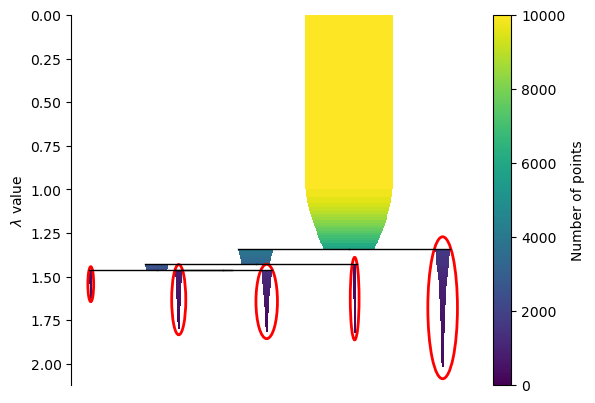

In [265]:
hdbscan_model.condensed_tree_.plot(select_clusters=True)

In [272]:
hdbscan_model.labels_

array([ 3, -1,  4, ...,  0, -1, -1])

Using the cluster labels, we can now visualise our clusters:

In [267]:
fig = px.scatter_3d(x=u[:,0], y=u[:, 1], z=u[:, 2],
                    color=hdbscan_model.labels_
                   )

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## 4. Topic extraction (class-based TF-IDF)
We then use c-TF-IDF to extract the topicof each cluster just created.

In [268]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [269]:
# # we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

In [270]:
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=sentence_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer_model,
    language='english',
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(data)

2024-02-15 02:33:44,071 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2024-02-15 02:34:10,715 - BERTopic - Embedding - Completed ✓
2024-02-15 02:34:10,719 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-15 02:34:27,035 - BERTopic - Dimensionality - Completed ✓
2024-02-15 02:34:27,037 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-15 02:34:27,786 - BERTopic - Cluster - Completed ✓
2024-02-15 02:34:27,800 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-15 02:34:29,311 - BERTopic - Representation - Completed ✓


In [271]:
topic_model.visualize_barchart()

Above we can see the most relevant words that define each of our topic clusters. A potential limitation in using this dataset as some of the text sources, such as tweets and blog comments, may self-select for topics such as politics and current affairs which are less relevant to analysing payment text fields. This could be avoided by using a more relevant dataset to train the model.</br></br>
In addition, a more full-scale analysis would involve testing multiple parameters (such as min-samples) in order to visualise different levels of cluster separation, and determining a heuristic to select the best clustering.